Frog Distribution

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = './'

import pickle

In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'Level_1_GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [3]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax
...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera


In [4]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax,1
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera,0
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax,1
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax,1
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera,0
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax,1
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax,1
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera,0


In [5]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()

In [6]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [7]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

In [8]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(frog_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,ppt_mean,soil_mean,tmax_mean,tmin_mean
0,3463704693,2019-11-10,Australia,Australia,New South Wales,-33.466600,150.185000,Crinia Signifera,0,0,73.349998,65.083336,17.966669,7.081669
1,3463455363,2018-10-08,Australia,Australia,New South Wales,-33.833166,151.014700,Crinia Signifera,0,1,70.383331,50.116665,24.088335,13.050002
2,3463662977,2018-11-04,Australia,Australia,New South Wales,-33.714100,151.143000,Crinia Signifera,0,2,96.599998,74.966667,23.010002,12.643335
3,2806506373,2016-07-15,Australia,Australia,New South Wales,-33.907400,150.833720,Crinia Signifera,0,3,63.183334,44.816666,24.073334,11.728335
4,3463505407,2018-12-21,Australia,Australia,New South Wales,-33.759766,151.113259,Crinia Signifera,0,4,84.050003,65.483330,23.581669,13.054999


In [9]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)

train_x, validation_x, train_y, validation_y = train_test_split(X, y, test_size=0.2, random_state=207)

# Fit model
full_model.fit(train_x, train_y)

# save
with open('Saved_Models/logistic_regression.pkl','wb') as f:
    pickle.dump(full_model,f)

In [10]:
train_predictions = full_model.predict(train_x)
validation_predictions = full_model.predict(validation_x)

In [11]:
print(f"Training F1 Score: {np.mean(f1_score(train_y, train_predictions)).round(2)}")
print(f"Training Accuracy: {np.mean(accuracy_score(train_y, train_predictions)).round(2)}")
print(f"Validation F1 Score: {np.mean(f1_score(validation_y, validation_predictions)).round(2)}")
print(f"Validation Accuracy: {np.mean(accuracy_score(validation_y, validation_predictions)).round(2)}")

Training F1 Score: 0.67
Training Accuracy: 0.64
Validation F1 Score: 0.7
Validation Accuracy: 0.66


In [12]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [14]:
# ''' Adam Optimizer
optimizer = keras.optimizers.Adam(
    learning_rate=0.0005, # need fine-tune
    beta_1=0.9, # need fine-tune
    beta_2=0.999, # need fine-tune
    epsilon=1e-07, # need fine-tune
    amsgrad=False,
    name='Adam'
)
# '''

# Normal Gradient Descent
# optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.0005, use_locking=False, name='GradientDescent')

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              # tfa.metrics.F1Score(num_classes=2)用法需要再研究一下
    
# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# train_dataset = train_dataset.shuffle(buffer_size=256).batch(64) # 需要确定是否要用mini-batch 感觉没必要
train_dataset = train_dataset.batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))
val_dataset = val_dataset.batch(64)

history = model.fit(train_dataset, epochs=2000, validation_data=val_dataset)
model.save('Saved_Models/test_convergence')


Epoch 1/2000
70/70 [==============================] - 2s 9ms/step - loss: 0.8860 - accuracy: 0.5836 - val_loss: 0.6401 - val_accuracy: 0.6434
Epoch 2/2000
70/70 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6463 - val_loss: 0.6232 - val_accuracy: 0.6559
Epoch 3/2000
70/70 [==============================] - 0s 6ms/step - loss: 0.6118 - accuracy: 0.6521 - val_loss: 0.5961 - val_accuracy: 0.6685
Epoch 4/2000
70/70 [==============================] - 0s 7ms/step - loss: 0.5980 - accuracy: 0.6624 - val_loss: 0.5851 - val_accuracy: 0.6667
Epoch 5/2000
70/70 [==============================] - 0s 6ms/step - loss: 0.5918 - accuracy: 0.6682 - val_loss: 0.5733 - val_accuracy: 0.6738
Epoch 6/2000
70/70 [==============================] - 0s 4ms/step - loss: 0.5870 - accuracy: 0.6736 - val_loss: 0.5724 - val_accuracy: 0.6667
Epoch 7/2000
70/70 [==============================] - 0s 5ms/step - loss: 0.5835 - accuracy: 0.6779 - val_loss: 0.5653 - val_accuracy: 0.6720
Epoch 

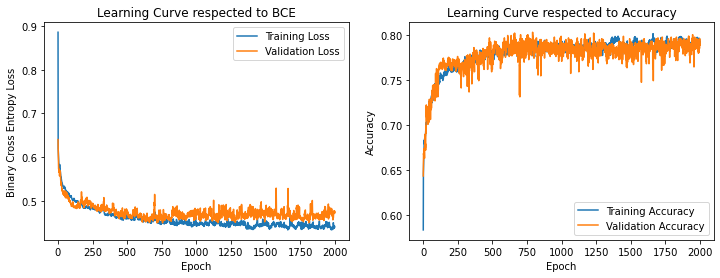

In [15]:
fig, ax1 = plt.subplots(1, 2, figsize=(12, 4))
ax1[0].plot(history.history['loss'], label="Training Loss")
ax1[0].plot(history.history['val_loss'], label="Validation Loss")
ax1[1].plot(history.history['accuracy'], label="Training Accuracy")
ax1[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
ax1[0].set_xlabel('Epoch')
ax1[1].set_xlabel('Epoch')
ax1[0].set_ylabel('Binary Cross Entropy Loss')
ax1[1].set_ylabel('Accuracy')
ax1[0].set_title('Learning Curve respected to BCE')
ax1[1].set_title('Learning Curve respected to Accuracy')
ax1[0].legend()
ax1[1].legend()
plt.show()

In [16]:
n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=207, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    train_x, validation_x = X.loc[train_index], X.loc[test_index]
    train_y, validation_y = y[train_index], y[test_index]
    
    # Prepare the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    train_dataset = train_dataset.shuffle(buffer_size=32).batch(64)

    # Prepare the validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))
    val_dataset = val_dataset.batch(64)
    
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ])

    # ''' Adam Optimizer
    optimizer = keras.optimizers.Adam(
        learning_rate=0.0005, # need fine-tune
        beta_1=0.9, # need fine-tune
        beta_2=0.999, # need fine-tune
        epsilon=1e-07, # need fine-tune
        amsgrad=False,
        name='Adam'
    )

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Fit the model with the training set
    model.fit(train_dataset, epochs=500) # converges at around 500
    
    model.save('Saved_Models/KFold_' + str(i + 1))
    
    predictions = tf.math.round(model.predict(validation_x))
    
    
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(validation_y, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(validation_y))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")



Fold 1 of 10
Epoch 1/500
79/79 [==============================] - 1s 3ms/step - loss: 1.6901 - accuracy: 0.9138
Epoch 2/500
79/79 [==============================] - 0s 3ms/step - loss: 2.7754 - accuracy: 0.7863
Epoch 3/500
79/79 [==============================] - 0s 5ms/step - loss: 2.0154 - accuracy: 0.7770
Epoch 4/500
79/79 [==============================] - 1s 7ms/step - loss: 2.1535 - accuracy: 0.7481
Epoch 5/500
79/79 [==============================] - 1s 6ms/step - loss: 1.7488 - accuracy: 0.6969
Epoch 6/500
79/79 [==============================] - 0s 4ms/step - loss: 1.4766 - accuracy: 0.5354
Epoch 7/500
79/79 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.2407
Epoch 8/500
79/79 [==============================] - 0s 6ms/step - loss: 0.8627 - accuracy: 0.4960
Epoch 9/500
79/79 [==============================] - 1s 7ms/step - loss: 0.6952 - accuracy: 0.3889
Epoch 10/500
79/79 [==============================] - 0s 5ms/step - loss: 0.7736 - accuracy: 0.5

KeyboardInterrupt: 

In [ ]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

To Do Test for Submission